In [1]:
from neurotools import models # my neuro and ml experimental code library
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd

Load the atlas volume file and associated lookup table. This atlas defines visual system rois seperated by hemisphere and ventral / dorsal.

In [2]:
atlas_nii = nib.load("/home/ssbeast/Projects/SS/monkey_fmri/CCSF/subjects/pollux/templates/combined_atlas.nii")
atlas = torch.round(torch.from_numpy(atlas_nii.get_fdata())).int()
lookup = pd.read_csv("/home/ssbeast/Projects/SS/monkey_fmri/CCSF/subjects/pollux/templates/atlas_lookup.txt", header=0, index_col=0, delimiter='\t')

Load curated beta matrices for each subject (registered to template). Then select betas corresponding to defined regions in the atlas, and reshape from (w x h x d x features) to (voxels x features). Also standardize across the feature dimension to remove any spatial magnitude differences.

In [3]:
# grab the shape color beta matrix for pollux
beta = '/home/ssbeast/Projects/SS/monkey_fmri/CCSF/subjects/pollux/analysis/curated_betas.nii.gz'
beta_nii = nib.load(beta)
affine = beta_nii.affine
header = beta_nii.header
beta = np.array(beta_nii.get_fdata())
flat_beta = torch.from_numpy(beta)[(atlas > 0)]
flat_beta = (flat_beta - flat_beta.mean(axis=0).unsqueeze(0)) / flat_beta.std(axis=0).unsqueeze(0)
flat_beta = flat_beta.float()

# grab the shape color beta matrix for castor
beta = '/home/ssbeast/Projects/SS/monkey_fmri/CCSF/subjects/castor/analysis/reg_curated_betas.nii.gz'
beta_nii = nib.load(beta)
affine2 = beta_nii.affine
header2 = beta_nii.header
beta = np.array(beta_nii.get_fdata())
flat_beta2 = torch.from_numpy(beta)[(atlas > 0)]
flat_beta2 = (flat_beta2 - flat_beta2.mean(axis=0).unsqueeze(0)) / flat_beta2.std(axis=0).unsqueeze(0)
flat_beta2 = torch.from_numpy(np.nan_to_num(flat_beta2.float().numpy()))

flat_beta = flat_beta2 + flat_beta

Flatten the atlas itself as well so indexes match the betas

In [4]:
flat_atlas = atlas[atlas > 0].float()

Below are the feature descriptions for the betas, corresponding to columns. These betas have m=16 features.

In [5]:
feature_names = ['daylight_high_sat', 'daylight_low_sat', 'antidaylight_high_sat', 'antidaylight_low_sat', 'lm_high_sat', 'lm_low_sat', 's_high_sat', 's_low_sat', 'lms_high_sat', 'lms_low_sat', 'lm_high_freq', 'lm_low_freq', 's_high_freq', 's_low_freq', 'lms_high_freq', 'lms_low_freq']

Initialize and fit the Supervised Embedding model. Given number of components k, the model uses a (m x k) linear transform matrix T to take the betas into k dimmensional eucloidean space. Via gradiant decent, we find a T that  maximizes the pairwise distance between class (ROI label) centroids, while minimizing variance within those classes, and making T as sparse as possible. Explicitly, we find:
$$\bold{argmin}_{T} \quad [-\sum_{\forall f_1 \in R} \sum_{\forall f_2 \in R} \frac {\sqrt{ \sum_{k}(\overline{\beta_{f_1} T} - \overline{\beta_{f_2}T})^2}}{|R|^2} + \sum_{\forall f \in R} \frac{(\beta_{f}T - \overline{\beta_{f}T})^2}{(|f| - 1)|R|} + \sum |T|]$$
where $R$ is the set of ROI labels, $T$ is the transform we're trying to discover (the set of k component vectors) and $\beta$ is the beta matrix with $m$ features and $k$ is the number of target components or dimensions. Note that $f$ is used to denote all voxels that pertain to a certain ROI.

First we'll try running with a quite lenient sparsity parameter, which will produce complex component vectors, but give a good idea of the space.

In [7]:
super_embed_1 = models.SupervisedEmbed(n_components=2, sparsity=.1, intra_class_weight=1., inter_class_weight=1., device='cpu')
super_embed_1.fit(flat_beta, flat_atlas, max_iter=200000, verbose=True, converge_var=.002)


iteration 0 loss is 11.529004096984863
iteration 1 loss is 11.349361419677734
iteration 2 loss is 11.167679786682129
iteration 3 loss is 10.984156608581543
iteration 4 loss is 10.798993110656738
iteration 5 loss is 10.612393379211426
iteration 6 loss is 10.42457103729248
iteration 7 loss is 10.235727310180664
iteration 8 loss is 10.046056747436523
iteration 9 loss is 9.856435775756836
iteration 10 loss is 9.668182373046875
iteration 11 loss is 9.479791641235352
iteration 12 loss is 9.291478157043457
iteration 13 loss is 9.10341739654541
iteration 14 loss is 9.06684398651123
iteration 15 loss is 9.187904357910156
iteration 16 loss is 9.269442558288574
iteration 17 loss is 9.318429946899414
iteration 18 loss is 9.339536666870117
iteration 19 loss is 9.337179183959961
iteration 20 loss is 9.316689491271973
iteration 21 loss is 9.279678344726562
iteration 22 loss is 9.2280912399292
iteration 23 loss is 9.165322303771973
iteration 24 loss is 9.091999053955078
iteration 25 loss is 9.00952148

Neato, now we extract the optimal components found by the model, and zero any values that are already close to 0. We also get the projection of $\beta$ into the $k$ dimensional target space so we can plot it up.

In [8]:
components = super_embed_1.get_components().detach().cpu()
components[torch.isclose(components, torch.zeros((1,)), atol=.1)] = 0
proj = super_embed_1.predict(flat_beta)

For human readability, we automatically create descriptors for the components based on their contents, they are the column headers below

In [9]:
component_names = []
np_feats = np.array(feature_names)
compts = components.T
for comp in compts:
    pos_feats = np_feats[comp > 0]
    neg_feats = np_feats[comp < 0]
    component_name = "[" + " + ".join(pos_feats.tolist()) + "] - [" + " + ".join(neg_feats.tolist()) + "]"
    component_names.append(component_name)
compts = pd.DataFrame(components)
compts.columns = component_names
compts.head(16)

,[antidaylight_low_sat + lms_low_sat + lms_low_freq] - [daylight_high_sat],[daylight_high_sat + daylight_low_sat + s_low_sat + lms_low_freq] - [lms_high_sat]
0,-3.293807,0.156124
1,0.000000,0.749092
2,0.000000,0.000000
3,0.727240,0.000000
4,0.000000,0.000000
5,0.000000,0.000000
6,0.000000,0.000000
7,0.000000,1.803217
8,0.000000,-3.290969
9,1.679624,0.000000


Now plot the rois in the embedding space:

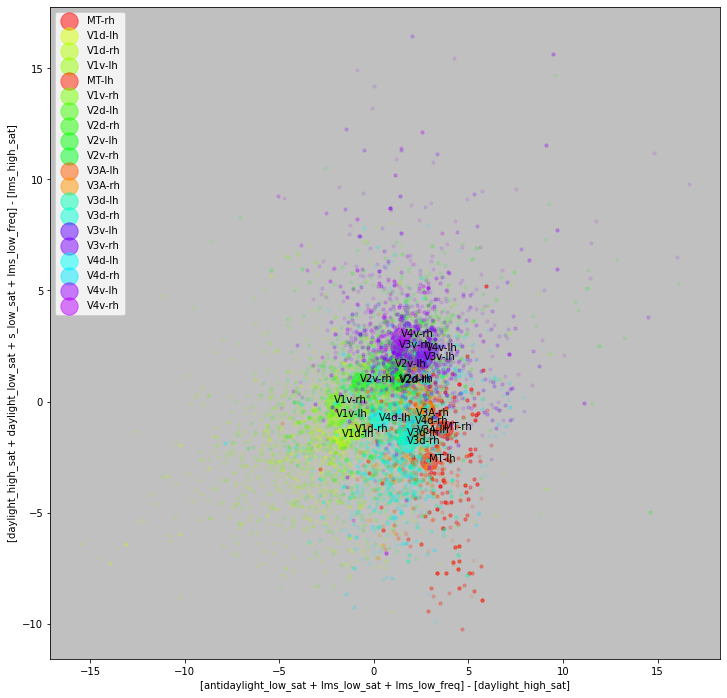

In [10]:
USE_3D = False # set to true if u want to show embedding in 3 dims instead of 2

if USE_3D:
    # if 3d plot we need to open a separate window to see interactive plot
    %matplotlib qt
    fig = plt.figure()
    ax = plt.axes(projection='3d')
else:
    %matplotlib inline
    fig = plt.figure()
    ax =  plt.axes()

our_cvals = [0.0, .2, .22, .24, 0.02, .26 , .3, .32, .34, .36, .06, .10, .46, .48, .74, .76, .50, .52, .78, .8]
atlas_idxs = sorted(torch.unique(atlas).tolist())[1:]
fig.set_size_inches((12, 12))
idxs = torch.randperm(proj.shape[0])[:]
proj_sample = proj[idxs, :]
cmap = plt.get_cmap('hsv')
num_rois = len(atlas_idxs)
for i, key in enumerate(atlas_idxs[:]):
    c = cmap(our_cvals[i])
    label = lookup.loc[key]['Label Name:']
    roi_proj = proj_sample[flat_atlas[idxs]==key, :]
    mean, _ = torch.median(roi_proj, dim=0)
    ind = np.random.choice(np.arange(len(roi_proj)), 500)
    roi_proj = roi_proj[ind]
    ax.set_xlabel(component_names[0])
    ax.set_ylabel(component_names[1])
    if USE_3D:
        ax.scatter(roi_proj[:, 0], roi_proj[:, 1], roi_proj[:, 2], s=10, color=c, alpha=.1)
        ax.scatter(mean[0], mean[1], mean[2], s=300, color=c, marker='o', label=label, alpha=.5)
        ax.text(mean[0], mean[1], mean[2], label)
        ax.set_ylabel(component_names[2])
    else:
        ax.scatter(roi_proj[:, 0], roi_proj[:, 1], s=10, color=c, alpha=.1)
        ax.scatter(mean[0], mean[1], s=300, color=c, marker='o', label=label, alpha=.5)
        ax.text(mean[0], mean[1], label)
    # ax.set_ylim(-5, 5)
    # ax.set_xlim(-5, 5)

ax.set_facecolor('silver')
plt.legend()
plt.show()

Okay, thats nice, there's definitely some structure to the space generated. It seems like there's 5 major clusters, v3 / v4 ventral, v1 / v2, v3 / v4 dorsal, v3a, and MT. Now we'll combine labels for those categories, and rerun the algorithm. This is useful because now the model won't try to seperate these grouped categories, and will try to minimize variance within them.

In [37]:
new_labels = np.zeros(len(flat_atlas))
# label_groups = [[2, 3, 4, 6], [7, 8, 9, 10], [1, 5], [11, 12], [15, 16, 19, 20], [13, 14, 17, 18]]
label_groups = [[7, 8, 9, 10], [1, 5], [11, 12], [15, 16, 19, 20], [13, 14, 17, 18]]
relabeled_names = ['V2', 'MT', 'V3a', 'V3/4 V', 'V3/4 D']
for i, group in enumerate(label_groups):
    for idx in group:
        new_labels[flat_atlas==idx] = i
new_beta = flat_beta[new_labels > 0]
new_labels = torch.from_numpy(new_labels[new_labels > 0])

Create a new model with higher sparsity parameters

In [44]:
super_embed_2 = models.SupervisedEmbed(n_components=2, sparsity=.1, intra_class_weight=1.2, inter_class_weight=1., device='cpu')
super_embed_2.fit(new_beta, new_labels, max_iter=200000, verbose=True, converge_var=.01)

iteration 0 loss is 13.034884452819824
iteration 1 loss is 12.853414535522461
iteration 2 loss is 12.669426918029785
iteration 3 loss is 12.4830904006958
iteration 4 loss is 12.29458236694336
iteration 5 loss is 12.104084014892578
iteration 6 loss is 11.911775588989258
iteration 7 loss is 11.717836380004883
iteration 8 loss is 11.523332595825195
iteration 9 loss is 11.328798294067383
iteration 10 loss is 11.133343696594238
iteration 11 loss is 10.937203407287598
iteration 12 loss is 10.740599632263184
iteration 13 loss is 10.543746948242188
iteration 14 loss is 10.346850395202637
iteration 15 loss is 10.150091171264648
iteration 16 loss is 9.954824447631836
iteration 17 loss is 9.761075973510742
iteration 18 loss is 9.625550270080566
iteration 19 loss is 9.689279556274414
iteration 20 loss is 9.713281631469727
iteration 21 loss is 9.707813262939453
iteration 22 loss is 9.679791450500488
iteration 23 loss is 9.634254455566406
iteration 24 loss is 9.5750093460083
iteration 25 loss is 9.5

Extract components from the model again, and make them human readable

In [45]:
components = super_embed_2.get_components().detach().cpu()
components[torch.isclose(components, torch.zeros((1,)), atol=.1)] = 0
proj = super_embed_2.predict(flat_beta)

In [46]:
component_names = []
np_feats = np.array(feature_names)
compts = components.T
for comp in compts:
    pos_feats = np_feats[comp > 0]
    neg_feats = np_feats[comp < 0]
    component_name = "[" + " + ".join(pos_feats.tolist()) + "] - [" + " + ".join(neg_feats.tolist()) + "]"
    component_names.append(component_name)
compts = pd.DataFrame(components)
compts.columns = component_names
compts.head(16)

,[antidaylight_high_sat + s_low_freq] - [daylight_low_sat + lm_low_sat + lm_high_freq + lms_high_freq],[daylight_high_sat + daylight_low_sat + s_low_sat + lms_low_freq] - [lms_high_sat + lms_low_sat + lms_high_freq]
0,0.000000,1.239619
1,-1.251688,0.233580
2,2.089803,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,-0.590954,0.000000
6,0.000000,0.000000
7,0.000000,1.602577
8,0.000000,-2.362513
9,0.000000,-1.110668


Plot the sparse embedding results

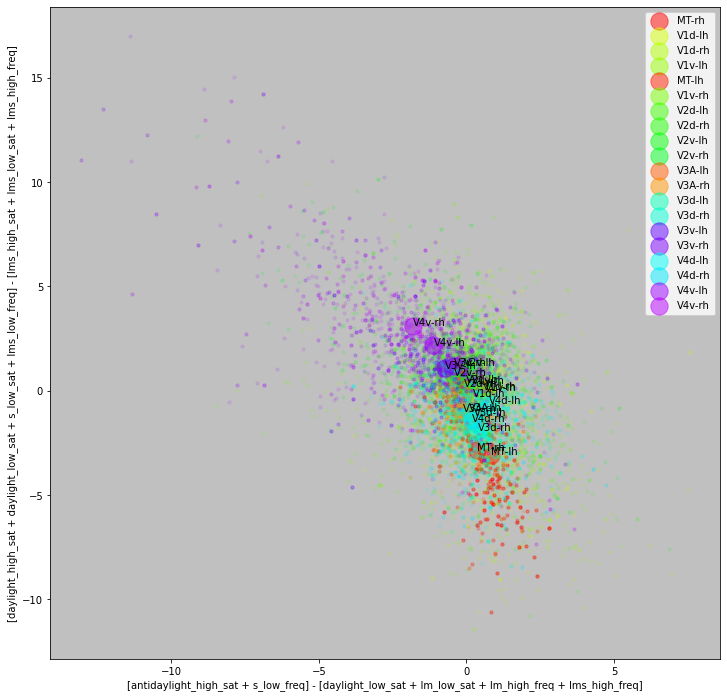

In [47]:
USE_3D = False # set to true if u want to show embedding in 3 dims instead of 2

if USE_3D:
    # if 3d plot we need to open a separate window to see interactive plot
    %matplotlib qt
    fig = plt.figure()
    ax = plt.axes(projection='3d')
else:
    %matplotlib inline
    fig = plt.figure()
    ax = plt.axes()

our_cvals = [0.0, .2, .22, .24, 0.02, .26 , .3, .32, .34, .36, .06, .10, .46, .48, .74, .76, .50, .52, .78, .8]
atlas_idxs = sorted(torch.unique(atlas).tolist())[1:]
fig.set_size_inches((12, 12))
idxs = torch.randperm(proj.shape[0])[:]
proj_sample = proj[idxs, :]
cmap = plt.get_cmap('hsv')
num_rois = len(atlas_idxs)
for i, key in enumerate(atlas_idxs[:]):
    c = cmap(our_cvals[i])
    label = lookup.loc[key]['Label Name:']
    roi_proj = proj_sample[flat_atlas[idxs]==key, :]
    mean, _ = torch.median(roi_proj, dim=0)
    ind = np.random.choice(np.arange(len(roi_proj)), 500)
    roi_proj = roi_proj[ind]
    ax.set_xlabel(component_names[0])
    ax.set_ylabel(component_names[1])
    if USE_3D:
        ax.scatter(roi_proj[:, 0], roi_proj[:, 1], roi_proj[:, 2], s=10, color=c, alpha=.1)
        ax.scatter(mean[0], mean[1], mean[2], s=300, color=c, marker='o', label=label, alpha=.5)
        ax.text(mean[0], mean[1], mean[2], label)
        ax.set_ylabel(component_names[2])
    else:
        ax.scatter(roi_proj[:, 0], roi_proj[:, 1], s=10, color=c, alpha=.1)
        ax.scatter(mean[0], mean[1], s=300, color=c, marker='o', label=label, alpha=.5)
        ax.text(mean[0], mean[1], label)
        # ax.set_ylim(-10, 10)
        # ax.set_xlim(-10, 10)

ax.set_facecolor('silver')
plt.legend()
plt.show()

The two axes discovered represent in general Antidaylight and S vs. Daylight and LM on the X axis, and response to daylight and s vs gray (lms) on the y axis.
conclusions from this:
- The ventral areas can be characterised as having less response to the antidaylight and s axis, and more response to the daylight and lm axis compared to the dorsal areas.
- MT shows the least overall color response.
- Dorsal V3 and V4 have similar response along color dimensions to v1 and v2